In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import torch
from experiments import intervention_utils
import os
from cem.data.CUB200.cub_loader import load_data, find_class_imbalance
from torchvision.models import resnet50, resnet34
from cem.models.cem import ConceptEmbeddingModel
import pytorch_lightning as pl
import numpy as np
import cem.train.training as cem_train
import re
import random
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from cem.models.vae_model import *

2023-02-24 13:53:12.024648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 13:53:14.561790: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-24 13:53:42.145518: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: ../../anaconda3/lib
2023-02-24 13:53:42.146777: W tensorflow/compiler/xla/stream_execut

In [6]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)

## Dataset and Model Setup

In [7]:
CUB_DIR = 'CUB/'
BASE_DIR = os.path.join(CUB_DIR, 'images/CUB_200_2011/images')
num_workers=8
n_tasks = 200
n_concepts = 112
gpu = 0
sample_train = 0.1
concept_group_map = intervention_utils.CUB_CONCEPT_GROUP_MAP
num_epochs = 100
seed = 42

In [8]:
train_data_path = os.path.join(CUB_DIR, 'preprocessed/train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')
test_data_path = train_data_path.replace('train.pkl', 'test.pkl')

In [9]:
config = joblib.load("results/ConceptEmbeddingModelNew_resnet34_fold_1_experiment_config.joblib")

In [10]:
if config['weight_loss']:
    imbalance = find_class_imbalance(train_data_path, True)
else:
    imbalance = None

In [11]:
selected_concepts = np.arange(n_concepts)
def subsample_transform(sample):
    if isinstance(sample, list):
        sample = np.array(sample)
    return sample[selected_concepts]

In [12]:
train_dl = load_data(
    pkl_paths=[train_data_path],
    use_attr=True,
    no_img=False,
    batch_size=config['batch_size'],
    uncertain_label=False,
    n_class_attr=2,
    image_dir='images',
    resampling=False,
    root_dir='.',
    num_workers=config['num_workers'],
    concept_transform=subsample_transform,
    path_transform=lambda path: path.replace("CUB//",""),
)
val_dl = load_data(
    pkl_paths=[val_data_path],
    use_attr=True,
    no_img=False,
    batch_size=config['batch_size'],
    uncertain_label=False,
    n_class_attr=2,
    image_dir='images',
    resampling=False,
    root_dir='.',
    num_workers=config['num_workers'],
    concept_transform=subsample_transform,
    path_transform=lambda path: path.replace("CUB//",""))
test_dl = load_data(
    pkl_paths=[test_data_path],
    use_attr=True,
    no_img=False,
    batch_size=config['batch_size'],
    uncertain_label=False,
    n_class_attr=2,
    image_dir='images',
    resampling=False,
    root_dir='.',
    num_workers=config['num_workers'],
    concept_transform=subsample_transform,
    path_transform=lambda path: path.replace("CUB//","")
)

In [13]:
if sample_train < 1.0:
    train_dataset = train_dl.dataset
    train_size = round(len(train_dataset)*sample_train)
    train_subset = random.sample(range(0,len(train_dataset)),train_size)
    train_dataset = torch.utils.data.Subset(train_dataset, train_subset)
    sample_train_dl = torch.utils.data.DataLoader(train_dataset,batch_size=64, shuffle=True, 
                                           drop_last=True, num_workers=num_workers)



In [14]:
trainer = pl.Trainer(
            gpus=gpu,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## Baseline Intervention Results

In [15]:
def get_results(related_concepts,test_range=range(0,len(concept_group_map),4),trials=3):
    results_by_num_groups = {}
    for num_groups_intervened in test_range:
        results_by_num_groups[num_groups_intervened] = []
    
    config['related_concepts'] = related_concepts
    
    for trial in range(trials):
        pl.seed_everything(42+trial)
        for num_groups_intervened in test_range:
            intervention_idxs = intervention_utils.random_int_policy(
                        num_groups_intervened=num_groups_intervened,
                        concept_group_map=concept_group_map,
                        config=config,
                    )
                        
            model = intervention_utils.load_trained_model(
                        config=config,
                        n_tasks=n_tasks,
                        n_concepts=n_concepts,
                        result_dir="results/",
                        split=0,
                        imbalance=imbalance,
                        intervention_idxs=intervention_idxs,
                        train_dl=sample_train_dl,
                        sequential=False,
                        independent=False,
                    )

            [test_results] = trainer.test(model, val_dl, verbose=False,)
            results_by_num_groups[num_groups_intervened].append(test_results)
    return results_by_num_groups

In [20]:
results_baseline = get_results(None,[8],2)

Global seed set to 42
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


TypeError: cannot unpack non-iterable NoneType object

In [19]:
results_baseline

{8: [{'test_c_accuracy': 0.961543083190918,
   'test_c_auc': 0.9402127265930176,
   'test_c_f1': 0.9409788846969604,
   'test_y_accuracy': 0.8614357113838196,
   'test_y_auc': 0.0,
   'test_y_f1': 0.7751362323760986,
   'test_concept_loss': 0.6598849296569824,
   'test_task_loss': 0.6509348750114441,
   'test_loss': 3.9503591060638428,
   'test_avg_c_y_acc': 0.9114894270896912},
  {'test_c_accuracy': 0.961543083190918,
   'test_c_auc': 0.9402127265930176,
   'test_c_f1': 0.9409788846969604,
   'test_y_accuracy': 0.8672788143157959,
   'test_y_auc': 0.0,
   'test_y_f1': 0.7780300378799438,
   'test_concept_loss': 0.6598849296569824,
   'test_task_loss': 0.7078375220298767,
   'test_loss': 4.007262229919434,
   'test_avg_c_y_acc': 0.9144110083580017}]}

In [ ]:
x_vals = sorted([i for i in results_baseline])
y_vals = [results_baseline[i]['test_y_accuracy'] for i in x_vals]
plt.ylim([.75,1])
plt.plot(x_vals,y_vals)
plt.scatter(x_vals,y_vals)

## Random Intervention Results

In [113]:
random_related = {}
num_random_per = 10
identity_function = lambda s: s

for i in range(n_concepts):
    other_concepts = [j for j in range(n_concepts) if j!= i]
    our_concepts = random.sample(other_concepts,num_random_per)
    confidences = [random.random() for j in our_concepts]
    
    random_related[i] = {}
    
    for j in range(len(our_concepts)):
        random_related[i][our_concepts[j]] = (identity_function,confidences[j])
    

In [114]:
results_random = get_results(random_related)

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

In [81]:
x_vals = sorted([i for i in results_random])
y_vals = [results_random[i]['test_y_accuracy'] for i in x_vals]
plt.ylim([.75,1])
plt.plot(x_vals,y_vals)
plt.scatter(x_vals,y_vals)

## Intervening with Concept Vectors

In [101]:
def find_closest_vectors(matrix):
    num_vectors = matrix.shape[0]
    sim_matrix = cosine_similarity(matrix)

    # Set diagonal to -inf to exclude self-similarity
    np.fill_diagonal(sim_matrix, -np.inf)

    closest_indices = []
    for i in range(num_vectors):
        cosine_similarities = sim_matrix[i]
        distances = [(j, abs(sim),sim) for j, sim in enumerate(cosine_similarities)]
        # Sort by distance in descending order
        distances.sort(key=lambda x: x[1], reverse=True)
        # Get the indices of the 3 closest vectors (excluding itself)
        closest_indices.append([(j, sim) for j, d, sim in distances if j != i][:10])

    return closest_indices

In [68]:
concept2vec = np.load(open("concept_vectors/concept2vec.npy","rb"))
closest_vectors = find_closest_vectors(concept2vec)

In [70]:
related_concept2vec = {}
identity_function = lambda s: s
opposite_function = lambda s: 1-s

for i in range(n_concepts):
    related_concept2vec[i] = {}
    
    for index,similarity in closest_vectors[i]:
        confidence = similarity**2
        if similarity > 0:
            related_concept2vec[i][index] = (identity_function,confidence)
        else:
            related_concept2vec[i][index] = (opposite_function,confidence)

In [78]:
results_concept2vec = get_results(related_concept2vec)

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

In [79]:
x_vals = sorted([i for i in results_concept2vec])
y_vals = [results_concept2vec[i]['test_y_accuracy'] for i in x_vals]
plt.ylim([.75,1])
plt.plot(x_vals,y_vals)
plt.scatter(x_vals,y_vals)

In [102]:
labels = np.load(open("concept_vectors/labels.npy","rb"))
closest_vectors = find_closest_vectors(labels)

In [107]:
related_labels = {}
identity_function = lambda s: s
opposite_function = lambda s: 1-s

for i in range(n_concepts):
    related_labels[i] = {}
    
    for index,similarity in closest_vectors[i]:
        confidence = abs(similarity)
        if similarity > 0:
            related_labels[i][index] = (identity_function,confidence)
        else:
            related_labels[i][index] = (opposite_function,confidence)

In [110]:
results_labels = get_results(related_labels)
results_labels

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Testing: 0it [00:00, ?it/s]

{0: {'test_c_accuracy': 0.961543083190918,
  'test_c_auc': 0.9402127265930176,
  'test_c_f1': 0.9409788846969604,
  'test_y_accuracy': 0.7712854743003845,
  'test_y_auc': 0.0,
  'test_y_f1': 0.6555336713790894,
  'test_concept_loss': 0.6598849296569824,
  'test_task_loss': 1.6107624769210815,
  'test_loss': 4.910186767578125,
  'test_avg_c_y_acc': 0.8664143085479736},
 4: {'test_c_accuracy': 0.961543083190918,
  'test_c_auc': 0.9402127265930176,
  'test_c_f1': 0.9409788846969604,
  'test_y_accuracy': 0.8372287154197693,
  'test_y_auc': 0.0,
  'test_y_f1': 0.7421911954879761,
  'test_concept_loss': 0.6598849296569824,
  'test_task_loss': 0.7085254192352295,
  'test_loss': 4.007950305938721,
  'test_avg_c_y_acc': 0.899385929107666},
 8: {'test_c_accuracy': 0.961543083190918,
  'test_c_auc': 0.9402127265930176,
  'test_c_f1': 0.9409788846969604,
  'test_y_accuracy': 0.9056761264801025,
  'test_y_auc': 0.0,
  'test_y_f1': 0.8395071625709534,
  'test_concept_loss': 0.6598849296569824,
  'te

In [82]:
x_vals = sorted([i for i in results_labels])
y_vals = [results_labels[i]['test_y_accuracy'] for i in x_vals]
plt.ylim([.75,1])
plt.plot(x_vals,y_vals)
plt.scatter(x_vals,y_vals)

<IPython.core.display.Javascript object>


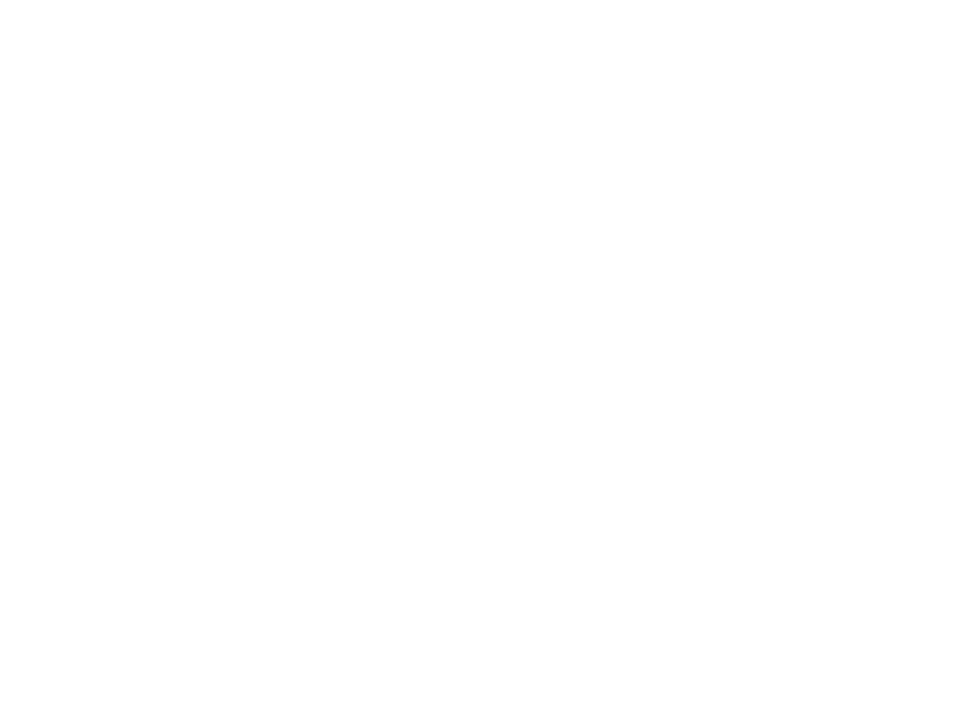

RecursionError: maximum recursion depth exceeded while calling a Python object

In [121]:
for dataset,name in zip([results_by_num_groups,results_random,results_concept2vec,results_labels],['normal','random','concept2vec','labels']):
    x_vals = sorted([i for i in dataset])
    y_vals = [dataset[i]['test_y_accuracy'] for i in x_vals]
    plt.ylim([.75,1])
    plt.plot(x_vals,y_vals,label=name)
    plt.scatter(x_vals,y_vals)
plt.legend()

## VAE-based concepts

In [12]:
def fix_concept(model,concepts):
    encoded_image = model.decoder.predict(np.array([concepts]))
    re_decoded_image = model.encoder.predict(encoded_image)
    
    return re_decoded_image
    

In [13]:
def get_results_vae(vae_model,test_range=range(0,len(concept_group_map),4)):
    results_by_num_groups = {}
    for num_groups_intervened in test_range:
        intervention_idxs = intervention_utils.random_int_policy(
                    num_groups_intervened=num_groups_intervened,
                    concept_group_map=concept_group_map,
                    config=config,
                )

        model = intervention_utils.load_trained_model(
                    config=config,
                    n_tasks=n_tasks,
                    n_concepts=n_concepts,
                    result_dir="results/",
                    split=0,
                    imbalance=imbalance,
                    intervention_idxs=intervention_idxs,
                    train_dl=sample_train_dl,
                    sequential=False,
                    independent=False,
                    vae_model=vae_model
                )

        [test_results] = trainer.test(model, val_dl, verbose=False,)
        results_by_num_groups[num_groups_intervened] = test_results
    return results_by_num_groups

In [14]:
config = joblib.load("results/ConceptBottleneckModelFuzzy_resnet34_fold_1_experiment_config.joblib")

In [15]:
latent_dim = 112
size = 64
decoder_3 = create_decoder(size,3,latent_dim)
encoder_3 = create_encoder(size,3,latent_dim)

model = VAE(encoder_3, decoder_3,concept_alignment=True)
model.built = True

2023-02-23 16:40:17.089124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-23 16:40:17.090124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login-q-4): /proc/driver/nvidia/version does not exist
2023-02-23 16:40:17.142726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.load_weights('concept_vectors/vae_concept.h5')

In [17]:
predicted_image = model.decoder.predict(np.random.random((1,112)))

1/1 [==============================] - 3s 3s/step


In [22]:
results_vae = get_results_vae(model,test_range=[4])

Testing: 0it [00:00, ?it/s]

Intervening in CBM!
c_pred shape torch.Size([128, 112])
4/4 [==============================] - 0s 5ms/step
Intervening in CBM!
c_pred shape torch.Size([128, 112])
4/4 [==============================] - 0s 4ms/step
Intervening in CBM!
c_pred shape torch.Size([128, 112])
4/4 [==============================] - 0s 3ms/step
Intervening in CBM!
c_pred shape torch.Size([128, 112])
4/4 [==============================] - 0s 4ms/step
Intervening in CBM!
c_pred shape torch.Size([128, 112])
4/4 [==============================] - 0s 16ms/step
Intervening in CBM!
c_pred shape torch.Size([128, 112])
4/4 [==============================] - 0s 4ms/step
Intervening in CBM!
c_pred shape torch.Size([128, 112])
4/4 [==============================] - 0s 4ms/step
Intervening in CBM!
c_pred shape torch.Size([128, 112])
4/4 [==============================] - 0s 4ms/step
Intervening in CBM!
c_pred shape torch.Size([128, 112])
4/4 [==============================] - 0s 3ms/step
Intervening in CBM!
c_pred shape tor

In [23]:
results_vae

{4: {'test_c_accuracy': 0.9619380235671997,
  'test_c_auc': 0.9345710277557373,
  'test_c_f1': 0.9408395886421204,
  'test_y_accuracy': 0.02003338932991028,
  'test_y_auc': 0.0,
  'test_y_f1': 0.011084546335041523,
  'test_concept_loss': 0.47675034403800964,
  'test_task_loss': 6.164934158325195,
  'test_loss': 8.548686027526855,
  'test_avg_c_y_acc': 0.4909856915473938}}

## Plot Results

In [6]:
results_by_algorithm = {}
for algorithm in ['labels','random','normal','concept2vec']:
    file_name = "results/intervention_{}.txt".format(algorithm)
    
    f = open(file_name).read().strip().split("\n")
    results_by_algorithm[algorithm] = {}
    
    for line in f:
        num_groups, trial, score = line.split(",")
        num_groups = int(num_groups)
        trial = int(num_groups)
        score = float(score)
        
        if num_groups not in results_by_algorithm[algorithm]:
            results_by_algorithm[algorithm][num_groups] = []
        results_by_algorithm[algorithm][num_groups].append(score)

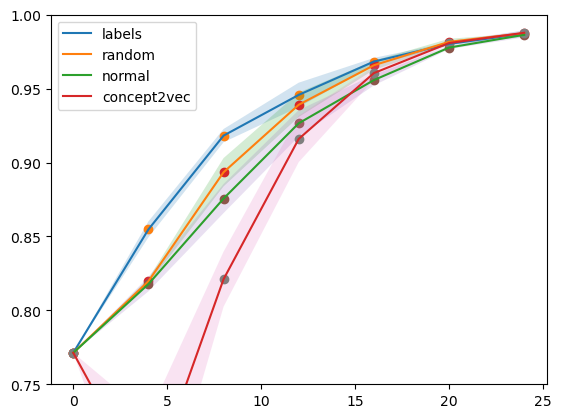

In [14]:
for algorithm in results_by_algorithm:
    x_vals = sorted([i for i in results_by_algorithm[algorithm]])
    x_vals = np.array(x_vals)
    y_vals = [results_by_algorithm[algorithm][i] for i in x_vals]
    y_vals_mean = [np.mean(i) for i in y_vals]
    y_vals_std = np.array([np.std(i) for i in y_vals])
    plt.ylim([.75,1])
    plt.plot(x_vals,y_vals_mean,label=algorithm)
    plt.fill_between(x_vals, y_vals_mean+y_vals_std, y_vals_mean-y_vals_std, alpha=0.2)

    plt.scatter(x_vals,y_vals_mean)
plt.legend()